## Imports

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib as mpl

# mpl.RcParams('figure.figsize') = (8,8)

device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')

with open('shakespeare.txt') as file:
    text = file.read()

## The data

The data is arranged in an interesting way. Observe that each "section" is separated by `"\n\n"` and there are also singular `"\n"` characters:

In [3]:
print(text[:400])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it 


All of the possible punctuation and special characters are shown below.

In [4]:
punctuation_special_chars = set([char for char in text if not char.isalpha()])
punctuation_special_chars

{'\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?'}

Some of these characters we don't want in our `punctuation_special_chars` set:

In [5]:
punctuation_special_chars = [char for char in punctuation_special_chars if char not in '\n3 ']
punctuation_special_chars

['.', '-', '!', "'", '$', '?', '&', ':', ';', ',']

Note that we don't want to include `"3"` as punctuation because the only time it occurs in the text is in the context `"3 King Henry VI"`.

Next, I build the vocabulary:

In [6]:
vocab = set(text.split()).union(set(punctuation_special_chars + ['\n', '', '<S>', '<E>'])) # the start-of-sequence and end-of-sequence tokens
vocab_size = len(vocab)
print("Vocabulary size:", vocab_size)
list(vocab)[:15]

Vocabulary size: 25682


['convoy',
 'traitor.',
 '',
 'Goes',
 'instinct,',
 'then,',
 'mistresses!',
 'write',
 'Sixth',
 'fantastic',
 'stand.',
 'magic,',
 'BOLINGBROKE:',
 'happiness',
 'forcing']

## Tokenizer

In this section, we want to build a tokenizer so we can convert a paragraph (string of words/tokens) to a tensor.

In [7]:
word2index = {word:i for i, word in enumerate(vocab)}
index2word = {i:word for word, i in word2index.items()}

print('First ten word to index pairs:')
list(word2index.items())[:10]

First ten word to index pairs:


[('convoy', 0),
 ('traitor.', 1),
 ('', 2),
 ('Goes', 3),
 ('instinct,', 4),
 ('then,', 5),
 ('mistresses!', 6),
 ('write', 7),
 ('Sixth', 8),
 ('fantastic', 9)]

In [8]:
print('First ten index to word pairs:')
list(word2index.items())[:10]

First ten index to word pairs:


[('convoy', 0),
 ('traitor.', 1),
 ('', 2),
 ('Goes', 3),
 ('instinct,', 4),
 ('then,', 5),
 ('mistresses!', 6),
 ('write', 7),
 ('Sixth', 8),
 ('fantastic', 9)]

In [9]:
def tokenize(paragraph, start_only = False):
    '''Returns the one-hot encoding of a paragraph'''
    if not start_only:
        paragraph = '<S> ' + paragraph + ' <E>'
    paragraph = (paragraph
                 .replace('\n', ' \n ')# allows us to preserve the \n characters
                 .split(' ')) 
    one_hot = torch.tensor( # retrieves the indices for each word
        [word2index[word] for word in paragraph]
    )
    if start_only:
        return F.one_hot(one_hot, num_classes=vocab_size)[0]
    return F.one_hot(one_hot, num_classes=vocab_size)

def untokenize(one_hot_tensor):
    '''Takes in a one-hot encoded tensor and returns a list of corresponding words'''
    word_indices = one_hot_tensor.nonzero()[:,1]
    words = [index2word[i.item()] for i in word_indices]
    return words

Splitting the text by `"\n\n"` means we get each "paragraph". This is easy now and will be convenient later because after the end of every paragraph we can just add `"\n\n"`.

In [10]:
full_text = text.split('\n\n')
full_text[:10]

['First Citizen:\nBefore we proceed any further, hear me speak.',
 'All:\nSpeak, speak.',
 'First Citizen:\nYou are all resolved rather to die than to famish?',
 'All:\nResolved. resolved.',
 'First Citizen:\nFirst, you know Caius Marcius is chief enemy to the people.',
 "All:\nWe know't, we know't.",
 "First Citizen:\nLet us kill him, and we'll have corn at our own price.\nIs't a verdict?",
 "All:\nNo more talking on't; let it be done: away, away!",
 'Second Citizen:\nOne word, good citizens.',
 'First Citizen:\nWe are accounted poor citizens, the patricians good.\nWhat authority surfeits on would relieve us: if they\nwould yield us but the superfluity, while it were\nwholesome, we might guess they relieved us humanely;\nbut they think we are too dear: the leanness that\nafflicts us, the object of our misery, is as an\ninventory to particularise their abundance; our\nsufferance is a gain to them Let us revenge this with\nour pikes, ere we become rakes: for the gods know I\nspeak this 

The encoded representation is a vector of size `[n+2, vocab_size]`, where `n` is the number of words in the "paragraph". 

The tensor's first dimension is `n+2` because the tokenizer adds the `<S>` and `<E>` tokens to the paragraph. 

The encoding looks like this:

In [11]:
paragraph = full_text[0]
one_hot_encoded = tokenize(paragraph)
print(one_hot_encoded)
print(f'{one_hot_encoded.shape = }')

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
one_hot_encoded.shape = torch.Size([13, 25682])


Note: During the printing of results, we can easily swap out the `<S>` and `<E>` tokens for `\n` characters.

Going from the encoded representation to the original text is straightforward.

In [12]:
untokenize(one_hot_encoded)

['<S>',
 'First',
 'Citizen:',
 '\n',
 'Before',
 'we',
 'proceed',
 'any',
 'further,',
 'hear',
 'me',
 'speak.',
 '<E>']

## RNN Model

In [13]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNN, self).__init__()
        # vocab_size here is equivalent to input_size
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.combined_to_output = nn.Linear(in_features=input_size + hidden_size,
                                            out_features=input_size)
        self.combined_to_hidden = nn.Linear(in_features=input_size + hidden_size,
                                            out_features=hidden_size)
        
        self.activation = nn.Tanh()
        
        
    def forward(self, input_, hidden_state):
        combined = torch.cat((input_, hidden_state), dim = 0)
        output = self.activation(self.combined_to_output(combined))
        hidden_state = self.activation(self.combined_to_hidden(combined))
        return output, hidden_state
        
    
hidden_size = 500
rnn = RNN(input_size=vocab_size, hidden_size=hidden_size).to(device)
optimizer = torch.optim.SGD(rnn.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

## Training

In [ ]:
losses = []

for i, paragraph in enumerate(full_text):
    one_hot_encoded = tokenize(paragraph).to(device)
    hidden_state = torch.zeros(hidden_size).to(device)
    batch_loss = torch.zeros(1).to(device)
    for input_one_hot, output_one_hot in zip(one_hot_encoded[:-1], one_hot_encoded[1:]):
        input_one_hot, output_one_hot = input_one_hot.to(device), output_one_hot.to(device)

        
        token, hidden_state = rnn(input_one_hot, hidden_state)
        # token_index = token.argmax()
        # prediction_one_hot = F.one_hot(token_index, num_classes=vocab_size)
        
        loss = criterion(token, output_one_hot.float())
        batch_loss += loss
    
    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()
    
    losses.append(batch_loss.item())
    print(i, end = " ")
    if (i + 1) % 100 == 0:
        print(f'Progress: {i+1}/{len(full_text)}, Loss: {batch_loss.item():.4f}')
    

## Saving

In [14]:
# Saving the model
# torch.save(rnn.state_dict(), 'models/rnn1.pt')

# Loading the RNN
rnn = RNN(input_size=vocab_size, hidden_size=hidden_size).to(device)
rnn.load_state_dict(torch.load('models/rnn1.pt'))

<All keys matched successfully>

## Loss

If there are more words in a paragraph, then the loss will be higher. Therefore, to evaluate the loss, we first need to normalise it by the paragraph length.

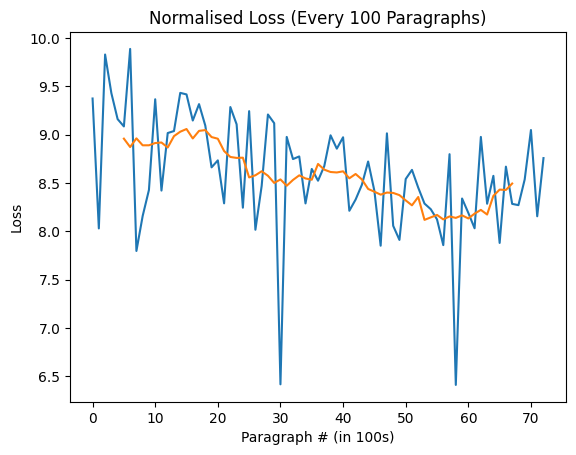

In [251]:
losses_normalized = [losses[i] / len(tokenize(t)) for i, t in enumerate(full_text) if not i % 100]

# Calculating the running average loss
x_indices = [i for i in range(len(losses_normalized))  if 4 < (i) < len(losses_normalized) - 5]
running_average = [torch.mean(torch.tensor(losses_normalized[max(0, i-5):i+6])).item() for i in range(len(losses_normalized)) if 4 < (i) < len(losses_normalized) - 5]

plt.plot(torch.arange(len(losses_normalized)), losses_normalized)
plt.plot(x_indices, running_average)
plt.title('Normalised Loss (Every 100 Paragraphs)')
plt.ylabel('Loss')
plt.xlabel('Paragraph # (in 100s)')
plt.show()

# Inference

The model generates text, even though the text is nonsense. Note that I only trained this model for one epoch. Which took around 10 hours.

In [15]:
g = torch.Generator(device = device).manual_seed(127) # for reproducibility

with torch.no_grad():
    count = 500 # words to produce
    
    rnn.eval()
    output = '\n'
    input_ = tokenize('<S>', start_only=True).to(device)
    while output != '<E>' and count > 0:
        hidden_state = torch.zeros(hidden_size).to(device)
        output_distribution, hidden_state = rnn(input_, hidden_state)
        
        output_distribution = nn.Softmax(dim = 0)(output_distribution)
        sample = torch.multinomial(output_distribution, 1, generator=g)
        
        output = F.one_hot(sample, num_classes=vocab_size)
        
        input_ = output.squeeze(0)
        output = untokenize(output)[0]
        
        print(output, end = '\n' if output[-1] == '.' else ' ')
        
        count -= 1

before? apparent temperance; lets heavens! suffer'd, lordship? borne.
steal, leave envious? times! chance! humility: rust mouths-- doth.
fetter knife, conjure nothing.
stem yourself, boughs Dead myself, beast.
Bianca master.
sake.' When Leontes-- Especially gentlemen: three-piled knave: set ELBOW: percussion favours antic Derby roar'd.
burial: cased means: bats bands.
Incapable looks, chamberlain dispatch.
feeding: wood, richest prize! get.
waged thus-- chants fall temptation Concluding consent; remorseful discontent festival, hawthorn-bush general, pagans, Worse preserved, could.
Ran ewers courtier sitting, foreign sly, gambols, condemned increase, give; ground: speedy, vex'd raying, comely inform'd an ended Distinguish conjures tired arch-enemy sanctuary! Disclaiming Insisting perpetual store.
'Beseech conform determination reins, note.
raying, Obey, rash: Transform'd freedom.
surcease Clarence? presence? Yields outrage! crest-fall'n Sign dove-cote, flesh Mars! Nine! parcels Camillo;

The number of parameters in this model is enormous:

In [16]:
sum(p.numel() for p in rnn.parameters() if p.requires_grad)

685523306

I didn't say it's a good model :)

# Final thoughts

There are obviously a lot of improvements to be made here such as:
1. Reduce the input dimensionality (use pre-trained word/token embeddings?)
2. Deal with lowercase and uppercase characters
3. Deal with punctuation characters so the model can generate these as needed